# Réseaux de neurones à convolution


Exemple de réseau de neurones à convolution (CNN) sur les données CIFAR10, avec pytorch
 

### SOMMAIRE  
[1. CNN](#xp1)  
[2. CNN avec augmentation de données et normalisation par batch](#xp2)  

[REQUIREMENTS.txt](#requirements)

### <a id='xp1'>CNN</a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import mlflow
import requests
import logging
import tempfile
from pathlib import Path
import os

In [2]:
logging.basicConfig(level=logging.INFO)
simple_logger = logging.getLogger(__name__)

In [3]:
# S3 key for artifacts storage
AWS_ACCESS_KEY_ID = "your-access-key"
AWS_SECRET_ACCESS_KEY = "your-secret-key"

In [4]:
# --- Setup MLFLOW

HOST = 'localhost'
PORT = '8090'
TRACKING_URI = f'http://{HOST}:{PORT}'

os.environ["AWS_ACCESS_KEY_ID"] = AWS_ACCESS_KEY_ID
os.environ["AWS_SECRET_ACCESS_KEY"] = AWS_SECRET_ACCESS_KEY
os.environ["MLFLOW_S3_ENDPOINT_URL"] = f'http://{HOST}:9000'

# --- Check mlflow version between client and server
req = requests.get(f'{TRACKING_URI}/version')

simple_logger.info('Checking MLflow Client and Server versions')
try:
    assert req.text == mlflow.__version__
except AssertionError as error:
    simple_logger.exception('MLflow Client and Server versions mismatch: client is {0} while server is {1}'.format(req.text, mlflow.__version__))


simple_logger.info('MLflow Client and Server versions identical. Setting up tracking uri..')

# Setup for experiment
mlflow.set_tracking_uri(uri=TRACKING_URI)
simple_logger.info('Tracking uri successfully set at {0}'.format(TRACKING_URI))

INFO:__main__:Checking MLflow Client and Server versions
INFO:__main__:MLflow Client and Server versions identical. Setting up tracking uri..
INFO:__main__:Tracking uri successfully set at http://localhost:8090


In [5]:
# --- Torchvision charger les données

train_dataset = torchvision.datasets.CIFAR10(
    root='../tmp',
    train=True,
    transform=transforms.ToTensor(),
    download=True
)

test_dataset = torchvision.datasets.CIFAR10(
    root='../tmp',
    train=False,
    transform=transforms.ToTensor(),
    download=True
)


100.0%


Extracting ../tmp\cifar-10-python.tar.gz to ../tmp
Files already downloaded and verified


In [6]:
print('Type du jeu d''entrainement:', type(train_dataset.data))
print('Shape du jeu d''entrainement:', train_dataset.data.shape)
print('Target du jeu d''entrainement: ', np.unique(train_dataset.targets))

Type du jeu dentrainement: <class 'numpy.ndarray'>
Shape du jeu dentrainement: (50000, 32, 32, 3)
Target du jeu dentrainement:  [0 1 2 3 4 5 6 7 8 9]


In [7]:
print('Type du jeu de test:', type(test_dataset.data))
print('Shape du jeu de test:', test_dataset.data.shape)
print('Target du jeu de test: ', np.unique(test_dataset.targets))

Type du jeu de test: <class 'numpy.ndarray'>
Shape du jeu de test: (10000, 32, 32, 3)
Target du jeu de test:  [0 1 2 3 4 5 6 7 8 9]


In [8]:
# --- Nombre de classes de la target
K = len(np.unique(train_dataset.targets))
K

10

In [9]:
# --- Création des dataloaders
batch_size = 128

train_loader = torch.utils.data.DataLoader(
    dataset = train_dataset,
    batch_size = batch_size,
    shuffle = True
)

test_loader = torch.utils.data.DataLoader(
    dataset = test_dataset,
    batch_size = batch_size,
    shuffle = False
)

In [10]:
class CNN(nn.Module):
    
    def __init__(self, K):
        '''
        Constructor for our custom cnn model
        '''
        super(CNN,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2)

        self.dense1 = nn.Linear(128 * 3 * 3, 1024)
        self.dense2 = nn.Linear(1024, K)
    
    def forward(self, X):
        '''
        Forward pass
        '''
        X = F.relu(self.conv1(X))
        X = F.relu(self.conv2(X))
        X = F.relu(self.conv3(X))
        X = X.view(-1, 128 * 3 * 3)
        X = F.dropout(X, p=0.5)
        X = F.relu(self.dense1(X))
        X = F.dropout(X, p=0.2)
        X = self.dense2(X)

        return X


model = CNN(K)

In [11]:
# --- GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

model.to(device)

cuda:0


CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
  (dense1): Linear(in_features=1152, out_features=1024, bias=True)
  (dense2): Linear(in_features=1024, out_features=10, bias=True)
)

In [12]:
# --- Entraîner le modèle

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs):
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)

    for it in range(epochs):
        model.train()
        t0 = datetime.now()
        train_loss = []

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())
        
        train_loss = np.mean(train_loss)
        mlflow.log_metric('train_loss', f'{train_loss:.4f}', step=it+1)

        model.eval()
        test_loss = []
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss.append(loss.item())
        
        test_loss = np.mean(test_loss)
        mlflow.log_metric('test_loss', f'{test_loss:.4f}', step=it+1)

        train_losses[it] = train_loss
        test_losses[it] = test_loss

        dt = datetime.now() - t0

        simple_logger.info('Epoch {0} /{1}\n-----------------'.format(it+1, epochs))
        simple_logger.info('Train Loss: {0:.4f}'.format(train_loss))
        simple_logger.info('Test Loss: {0:.4f}'.format(test_loss))
        simple_logger.info('Duration: {0}'.format(dt))

        # print(f'''Epoch {it+1}/{epochs}\n-----------------
        # Train Loss: {train_loss:.4f}
        # Test Loss: {test_loss:.4f}
        # Duration: {dt}
        # ''')
    return train_losses, test_losses

In [13]:
# --- MLflow set params and tags values
EXPERIMENT_NAME = 'CNN CIFAR10'
ARTIFACT_PATH = 'cifar10_model'
REGISTERED_MODEL_NAME = 'cifar10-cnn'

params = {
    'epochs': 15,
    'batch_size': batch_size,
    'loss_function': criterion.__class__.__name__,
    'optimizer': 'Adam'
}

tags = {
    'Main Method': 'classification',
    'version': '0.0.1'
}


In [14]:
# lancer la boucle d'entraînement

simple_logger.info('Setting up experiment')
try:
    experiment_id = mlflow.create_experiment(EXPERIMENT_NAME)
except:
    experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id


mlflow.set_experiment(experiment_id=experiment_id)
simple_logger.info('Experiment {0} successfully set'.format(EXPERIMENT_NAME))


with mlflow.start_run(run_name='Baseline run') as run:
    active_run_id = run.info.run_id
    
    mlflow.log_params(params)
    mlflow.set_tags(tags)

    with tempfile.TemporaryDirectory() as tmp_dir:
        path = Path(tmp_dir, 'model_definition.txt')
        path.write_text(str(model))
        mlflow.log_artifact(path, artifact_path=ARTIFACT_PATH)
    
    simple_logger.info('Starting training run...')
    train_losses, test_losses = batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs=params['epochs'])

    simple_logger.info('Training run completed. Logging model to MLflow server..')

    mlflow.pytorch.log_model(
        pytorch_model= model,
        artifact_path= ARTIFACT_PATH,
        registered_model_name = REGISTERED_MODEL_NAME
    )
    simple_logger.info('Model {0} has been successfully logged to MLflow server.'.format(REGISTERED_MODEL_NAME))

INFO:__main__:Setting up experiment
INFO:__main__:Experiment CNN CIFAR10 successfully set
INFO:botocore.credentials:Found credentials in environment variables.
INFO:__main__:Starting training run...
INFO:__main__:Epoch 1 /15
-----------------
INFO:__main__:Train Loss: 1.6502
INFO:__main__:Test Loss: 1.4304
INFO:__main__:Duration: 0:00:18.370408
INFO:__main__:Epoch 2 /15
-----------------
INFO:__main__:Train Loss: 1.3515
INFO:__main__:Test Loss: 1.2905
INFO:__main__:Duration: 0:00:17.631997
INFO:__main__:Epoch 3 /15
-----------------
INFO:__main__:Train Loss: 1.2205
INFO:__main__:Test Loss: 1.2006
INFO:__main__:Duration: 0:00:18.448645
INFO:__main__:Epoch 4 /15
-----------------
INFO:__main__:Train Loss: 1.1416
INFO:__main__:Test Loss: 1.1442
INFO:__main__:Duration: 0:00:18.328800
INFO:__main__:Epoch 5 /15
-----------------
INFO:__main__:Train Loss: 1.0649
INFO:__main__:Test Loss: 1.0863
INFO:__main__:Duration: 0:00:18.566087
INFO:__main__:Epoch 6 /15
-----------------
INFO:__main__:Tra

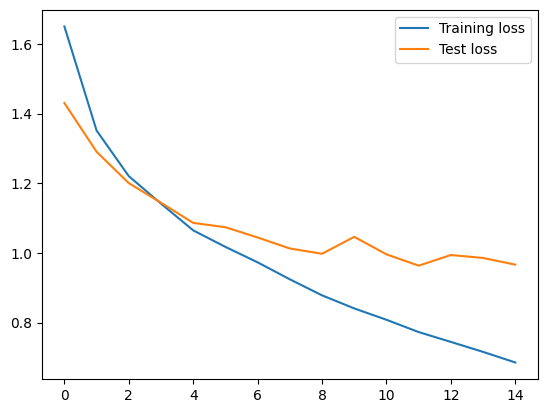

In [15]:
# Loss par itération
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Test loss')
plt.legend()
plt.show()

In [16]:
# Accuracy

model.eval()

# train
n_correct = 0.
n_total = 0.
for inputs, targets in train_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = model(inputs)
    _, predictions = torch.max(outputs, 1)
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

train_accuracy = n_correct/n_total

# test
n_correct = 0.
n_total = 0.
pred_test = np.array([])
for inputs, targets in test_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = model(inputs)
    _, predictions = torch.max(outputs, 1)
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

    pred_test = np.concatenate((pred_test, predictions.cpu()))

test_accuracy = n_correct/n_total

print(f'Train accuracy: {train_accuracy:.4f}, Test accuracy: {test_accuracy:.4f}')

# Add accuracy metrics to previous mlflow run
with mlflow.start_run(run_id=active_run_id):
    mlflow.log_metric('train_accuracy', train_accuracy)
    mlflow.log_metric('test_accuracy', test_accuracy)

Train accuracy: 0.7766, Test accuracy: 0.6713


2024/10/15 15:00:34 INFO mlflow.tracking._tracking_service.client: 🏃 View run Baseline run at: http://localhost:8090/#/experiments/1/runs/0995ebd5cefc48dfa618f3722bf8e48f.
2024/10/15 15:00:34 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:8090/#/experiments/1.


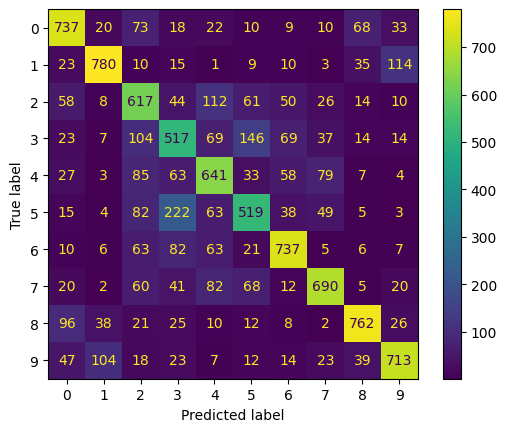

In [17]:
# --- Matrice de confusion

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

x_test = test_dataset.data
y_test = test_dataset.targets

cm = confusion_matrix(y_test, pred_test)

cm_display = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=np.unique(test_dataset.targets)
)

cm_display.plot()
plt.show()

In [18]:
true_labels = 'airplane,automobile,bird,cat,deer,dog,frog,horse,ship,truck'.split(',')

x_test = x_test.astype(np.uint8)
pred_test = pred_test.astype(np.uint8)


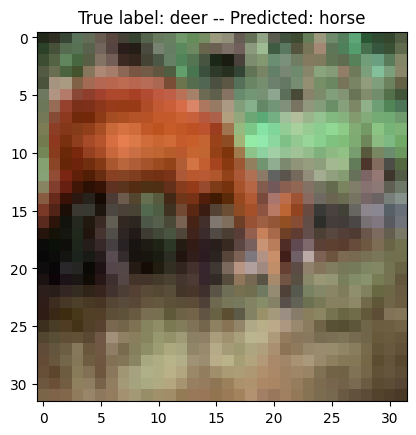

In [21]:
missclassified_idx = np.where(pred_test != y_test)[0]
i = np.random.choice(missclassified_idx)
plt.imshow(x_test[i])
plt.title(f'True label: {true_labels[y_test[i]]} -- Predicted: {true_labels[pred_test[i]]}')
plt.show()

### <a id='xp2'>CNN avec augmentation de données et normalisation par batch</a>

In [22]:
# --- fonctions de transformation PyTorch: https://pytorch.org/vision/stable/transforms.html
transformer_train = torchvision.transforms.Compose([
    # torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomCrop(32, padding=4),
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    # torchvision.transforms.RandomRotation(degrees=15),
    torchvision.transforms.RandomAffine(0, translate=(0.1, 0.1)),
    # torchvision.transforms.RandomPerspective(),
    transforms.ToTensor(),
])

In [23]:
# --- Torchvision : charger les données + appliquer les transformations

train_dataset = torchvision.datasets.CIFAR10(
    root='../tmp',
    train=True,
    transform=transformer_train,
    download=True
)

test_dataset = torchvision.datasets.CIFAR10(
    root='../tmp',
    train=False,
    transform=transforms.ToTensor(),
    download=True
)


Files already downloaded and verified
Files already downloaded and verified


In [24]:
# --- Création des dataloaders
batch_size = 128
train_loader = torch.utils.data.DataLoader(
    dataset = train_dataset,
    batch_size = batch_size,
    shuffle = True
)

test_loader = torch.utils.data.DataLoader(
    dataset = test_dataset,
    batch_size = batch_size,
    shuffle = False
)

In [25]:
class CNN(nn.Module):
    
    def __init__(self, K):
        '''
        Constructor for our custom cnn model that uses data augmentation and batch normalization
        '''
        super(CNN,self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),
        )
        
        self.dense1 = nn.Linear(128 * 4 * 4, 1024)
        self.dense2 = nn.Linear(1024, K)
    
    def forward(self, X):
        '''
        Forward pass
        '''
        X = F.relu(self.conv1(X))
        X = F.relu(self.conv2(X))
        X = F.relu(self.conv3(X))
        X = X.view(X.size(0), -1)
        X = F.dropout(X, p=0.5)
        X = F.relu(self.dense1(X))
        X = F.dropout(X, p=0.2)
        X = self.dense2(X)

        return X


model2 = CNN(K)

In [26]:
# --- GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

model2.to(device)

cuda:0


CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel

In [27]:
# --- Entraîner le modèle
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters())


In [28]:
EXPERIMENT_NAME = 'CNN CIFAR10'
ARTIFACT_PATH = 'cifar10_model'
REGISTERED_MODEL_NAME = 'improved-cifar10-cnn'

params = {
    'epochs': 80,
    'batch_size': batch_size,
    'loss_function': criterion.__class__.__name__,
    'optimizer': 'Adam'
}

tags = {
    'Main Method': 'classification',
    'version': '0.0.2'
}


In [29]:
# lancer la boucle d'entraînement

simple_logger.info('Setting up experiment')
try:
    experiment_id = mlflow.create_experiment(EXPERIMENT_NAME)
except:
    experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id


mlflow.set_experiment(experiment_id=experiment_id)
simple_logger.info('Experiment {0} successfully set'.format(EXPERIMENT_NAME))


with mlflow.start_run(run_name='Improved run') as run:
    active_run_id = run.info.run_id
    
    mlflow.log_params(params)
    mlflow.set_tags(tags)

    with tempfile.TemporaryDirectory() as tmp_dir:
        path = Path(tmp_dir, 'model_definition.txt')
        path.write_text(str(model))
        mlflow.log_artifact(path, artifact_path=ARTIFACT_PATH)
    
    simple_logger.info('Starting training run...')
    train_losses, test_losses = batch_gd(model2, criterion, optimizer, train_loader, test_loader, epochs=params['epochs'])

    simple_logger.info('Training run completed. Logging model to MLflow server..')

    mlflow.pytorch.log_model(
        pytorch_model= model2,
        artifact_path= ARTIFACT_PATH,
        registered_model_name = REGISTERED_MODEL_NAME
    )
    simple_logger.info('Model {0} has been successfully logged to MLflow server.'.format(REGISTERED_MODEL_NAME))

INFO:__main__:Setting up experiment
INFO:__main__:Experiment CNN CIFAR10 successfully set
INFO:__main__:Starting training run...
INFO:__main__:Epoch 1 /80
-----------------
INFO:__main__:Train Loss: 1.5326
INFO:__main__:Test Loss: 1.2320
INFO:__main__:Duration: 0:00:47.440950
INFO:__main__:Epoch 2 /80
-----------------
INFO:__main__:Train Loss: 1.0672
INFO:__main__:Test Loss: 1.0207
INFO:__main__:Duration: 0:00:46.647753
INFO:__main__:Epoch 3 /80
-----------------
INFO:__main__:Train Loss: 0.8948
INFO:__main__:Test Loss: 0.9700
INFO:__main__:Duration: 0:00:46.914860
INFO:__main__:Epoch 4 /80
-----------------
INFO:__main__:Train Loss: 0.7735
INFO:__main__:Test Loss: 0.8058
INFO:__main__:Duration: 0:00:46.958974
INFO:__main__:Epoch 5 /80
-----------------
INFO:__main__:Train Loss: 0.7163
INFO:__main__:Test Loss: 0.7209
INFO:__main__:Duration: 0:00:46.795303
INFO:__main__:Epoch 6 /80
-----------------
INFO:__main__:Train Loss: 0.6570
INFO:__main__:Test Loss: 0.6570
INFO:__main__:Duration

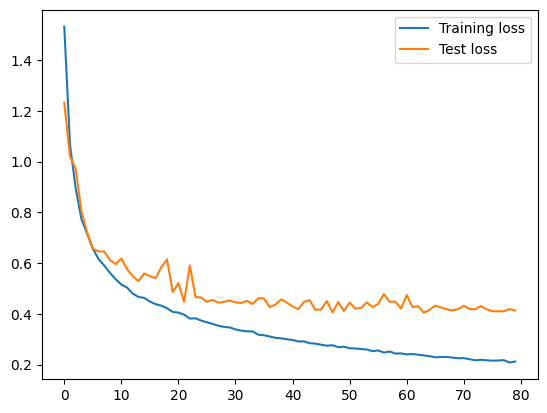

In [30]:
# Loss par itération
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Test loss')
plt.legend()
plt.show()

In [31]:
# Accuracy

model2.eval()

# train
n_correct = 0.
n_total = 0.
for inputs, targets in train_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = model2(inputs)
    _, predictions = torch.max(outputs, 1)
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

train_accuracy = n_correct/n_total

# test
n_correct = 0.
n_total = 0.
pred_test = np.array([])
for inputs, targets in test_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = model2(inputs)
    _, predictions = torch.max(outputs, 1)
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]
    pred_test = np.concatenate((pred_test, predictions.cpu()))

test_accuracy = n_correct/n_total

print(f'Train accuracy: {train_accuracy:.4f}, Test accuracy: {test_accuracy:.4f}')

# Add accuracy metrics to previous run
with mlflow.start_run(run_id=active_run_id):
    mlflow.log_metric('train_accuracy', train_accuracy)
    mlflow.log_metric('test_accuracy', test_accuracy)

Train accuracy: 0.9338, Test accuracy: 0.8764


2024/10/15 16:19:47 INFO mlflow.tracking._tracking_service.client: 🏃 View run Improved run at: http://localhost:8090/#/experiments/1/runs/fcfcd343c469454bb53d4a1ace055b24.
2024/10/15 16:19:47 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:8090/#/experiments/1.


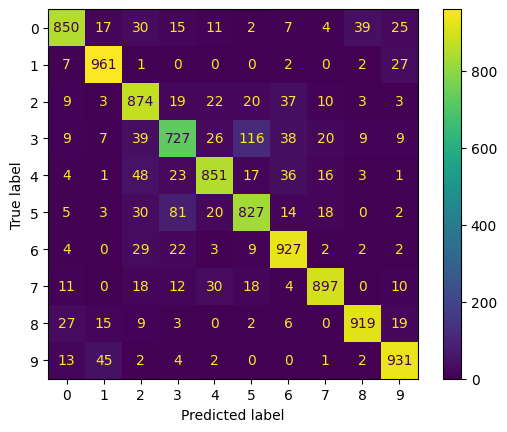

In [32]:
# --- Matrice de confusion

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


cm = confusion_matrix(y_test, pred_test)

cm_display = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=np.unique(test_dataset.targets)
)

cm_display.plot()
plt.show()

In [33]:
true_labels = 'airplane,automobile,bird,cat,deer,dog,frog,horse,ship,truck'.split(',')

x_test = x_test.astype(np.uint8)
pred_test = pred_test.astype(np.uint8)


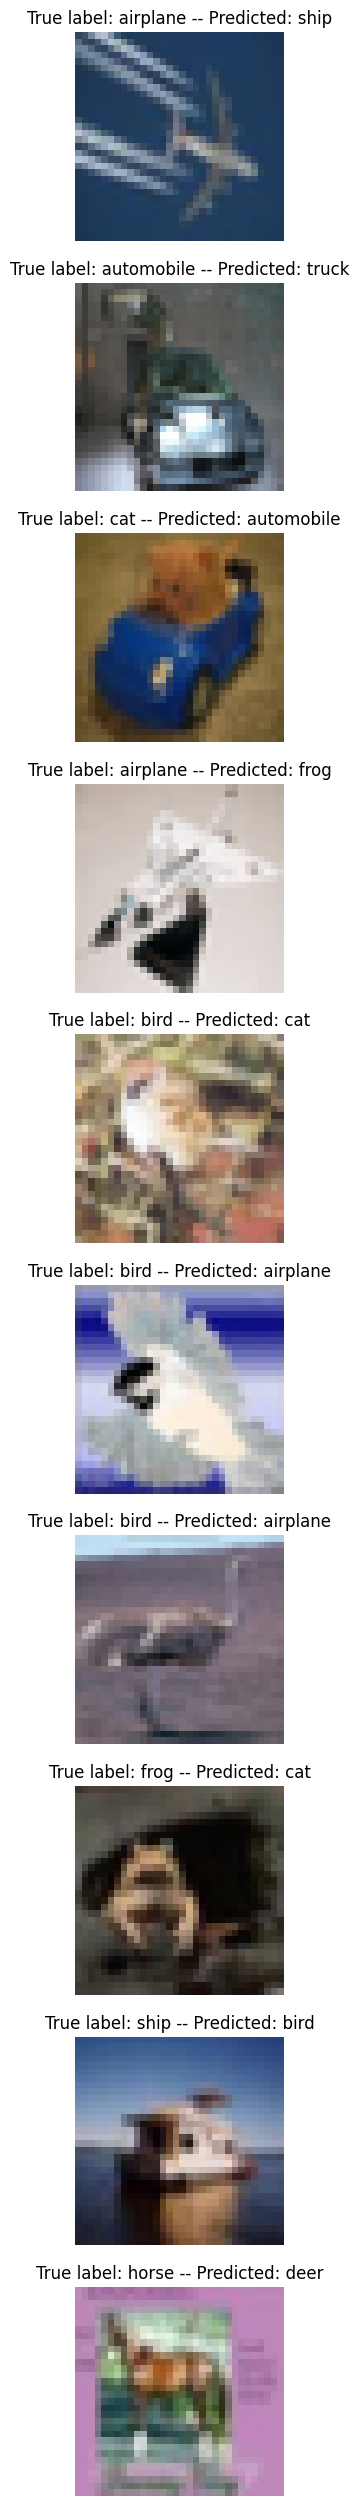

In [34]:
# --- Visualiser des exemples mauvaise prédiction

missclassified_idx = np.where(pred_test != y_test)[0]
sample_idx = np.random.choice(missclassified_idx, 10, replace=False)

plt.figure(figsize=(32,32))

for j, i in enumerate(sample_idx):
    plt.subplot(10, 1, j + 1)
    plt.axis('off')
    plt.imshow(x_test[i])
    plt.title(f'True label: {true_labels[y_test[i]]} -- Predicted: {true_labels[pred_test[i]]}')


## <a id="requirements" style="color:black">REQUIREMENTS.txt</a>

<span style="color:orange">Ce notebook a été créé avec python 3.10</span>

Requirements.txt  

```
alembic==1.13.2
aniso8601==9.0.1
anyio==4.4.0
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
arrow==1.3.0
asttokens==2.4.1
async-lru==2.0.4
attrs==23.2.0
Babel==2.15.0
bcrypt==4.1.3
beautifulsoup4==4.12.3      
bleach==6.1.0
blinker==1.8.2
boto3==1.35.35
botocore==1.35.40
cachetools==5.4.0
certifi==2024.6.2
cffi==1.16.0
charset-normalizer==3.3.2   
click==8.1.7
cloudpickle==3.0.0
colorama==0.4.6
comm==0.2.2
contourpy==1.2.1
cryptography==42.0.8        
cycler==0.12.1
databricks-sdk==0.31.1      
debugpy==1.8.1
decorator==5.1.1
defusedxml==0.7.1
Deprecated==1.2.14
docker==7.1.0
entrypoints==0.4
exceptiongroup==1.2.1
executing==2.0.1
fastjsonschema==2.19.1
filelock==3.13.1
Flask==3.0.3
fonttools==4.53.0
fqdn==1.5.1
fsspec==2024.2.0
gitdb==4.0.11
GitPython==3.1.43
google-auth==2.34.0
graphene==3.3
graphql-core==3.2.3
graphql-relay==3.2.0
greenlet==3.0.3
h11==0.14.0
httpcore==1.0.5
httpx==0.27.0
idna==3.7
imageio==2.35.1
importlib_metadata==7.1.0
intel-openmp==2021.4.0
ipykernel==6.29.4
ipython==8.25.0
ipywidgets==8.1.3
isoduration==20.11.0
itsdangerous==2.2.0
jedi==0.19.1
Jinja2==3.1.3
jmespath==1.0.1
joblib==1.4.2
json5==0.9.25
jsonpointer==3.0.0
jsonschema==4.22.0
jsonschema-specifications==2023.12.1
jupyter==1.0.0
jupyter-console==6.6.3
jupyter-events==0.10.0
jupyter-lsp==2.2.5
jupyter_client==8.6.2
jupyter_core==5.7.2
jupyter_server==2.14.1
jupyter_server_terminals==0.5.3
jupyterlab==4.2.2
jupyterlab_pygments==0.3.0
jupyterlab_server==2.27.2
jupyterlab_widgets==3.0.11
kiwisolver==1.4.5
lazy_loader==0.4
Mako==1.3.5
Markdown==3.6
MarkupSafe==2.1.5
matplotlib==3.9.0
matplotlib-inline==0.1.7
mistune==3.0.2
mkl==2021.4.0
mlflow==2.15.1
mlflow-skinny==2.15.1
mpmath==1.3.0
nbclient==0.10.0
nbconvert==7.16.4
nbformat==5.10.4
nest-asyncio==1.6.0
networkx==3.2.1
notebook==7.2.1
notebook_shim==0.2.4
numpy==1.26.3
opentelemetry-api==1.25.0
opentelemetry-sdk==1.25.0
opentelemetry-semantic-conventions==0.46b0
overrides==7.7.0
packaging==24.1
pandas==2.2.2
pandocfilters==1.5.1
paramiko==3.4.0
parso==0.8.4
pillow==10.2.0
platformdirs==4.2.2
prometheus_client==0.20.0
prompt_toolkit==3.0.47
protobuf==5.28.2
psutil==5.9.8
pure-eval==0.2.2
pyarrow==15.0.2
pyasn1==0.6.0
pyasn1_modules==0.4.0
pycparser==2.22
Pygments==2.18.0
PyNaCl==1.5.0
pyparsing==3.1.2
pysftp==0.2.8
python-dateutil==2.9.0.post0
python-json-logger==2.0.7
pytz==2024.1
pywin32==306
pywinpty==2.0.13
PyYAML==6.0.1
pyzmq==26.0.3
qtconsole==5.5.2
QtPy==2.4.1
querystring-parser==1.2.4
referencing==0.35.1
requests==2.32.3
rfc3339-validator==0.1.4
rfc3986-validator==0.1.1
rpds-py==0.18.1
rsa==4.9
s3transfer==0.10.3
scikit-image==0.24.0
scikit-learn==1.5.1
scipy==1.14.0
Send2Trash==1.8.3
six==1.16.0
smmap==5.0.1
sniffio==1.3.1
soupsieve==2.5
SQLAlchemy==2.0.31
sqlparse==0.5.1
stack-data==0.6.3
sympy==1.12
tbb==2021.11.0
terminado==0.18.1
threadpoolctl==3.5.0
tifffile==2024.9.20
tinycss2==1.3.0
tomli==2.0.1
torch==2.3.1+cu121
torchaudio==2.3.1+cu121
torchvision==0.18.1+cu121
tornado==6.4.1
traitlets==5.14.3
types-python-dateutil==2.9.0.20240316
typing_extensions==4.9.0
tzdata==2024.1
uri-template==1.3.0
urllib3==2.2.1
waitress==3.0.0
wcwidth==0.2.13
webcolors==24.6.0
webencodings==0.5.1
websocket-client==1.8.0
Werkzeug==3.0.3
widgetsnbextension==4.0.11
wrapt==1.16.0
zipp==3.19.2
```